In [1]:
# ==============================================================================
# CELL 1: CÀI ĐẶT, IMPORTS & THIẾT LẬP BAN ĐẦU (v3.0)
# ==============================================================================
import os
import json
import asyncio
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional
import operator

# Tải các biến môi trường
from dotenv import load_dotenv 
load_dotenv()

# LangChain & LangGraph
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

# Thư viện hỗ trợ & Kho tri thức
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from rich.console import Console
from rich.markdown import Markdown
from rich.pretty import pprint
from IPython.display import Image, display

# --- CẤU HÌNH LOG ---
VERBOSE_MODE = True

# --- KHỞI TẠO CÁC CÔNG CỤ ---
console = Console()

def print_step(message: str):
    if VERBOSE_MODE:
        console.print(f"[bold cyan]>[/bold cyan] {message}")

def print_result(data: Any, title: str = "Kết quả"):
    if VERBOSE_MODE:
        console.print(f"[bold green]✔️ {title}:[/bold green]")
        pprint(data, expand_all=True)
        
def print_warning(message: str):
    if VERBOSE_MODE:
        console.print(f"[bold yellow]⚠️  {message}[/bold yellow]")

# --- KHỞI TẠO LLM ---
try:
    llm = ChatGroq(
        temperature=0.1, model="llama3-70b-8192",
        api_key=os.getenv("GROQ_API_KEY"), max_tokens=3072
    )
    print("✅ LLM (Groq) đã được khởi tạo thành công.")
except Exception as e:
    print(f"❌ LỖI: Không thể khởi tạo LLM. Lỗi: {e}")
    llm = None

# --- TẢI KHO TRI THỨC ---
VECTOR_STORE_PATH = "vector_store/sgk_toan_9"
if os.path.exists(VECTOR_STORE_PATH):
    try:
        embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
        vector_store = FAISS.load_local(VECTOR_STORE_PATH, embeddings, allow_dangerous_deserialization=True)
        print("✅ Kho tri thức RAG đã được tải thành công.")
    except Exception as e:
        print(f"❌ LỖI khi tải kho tri thức: {e}")
        vector_store = None
else:
    print(f"❌ LỖI: Không tìm thấy kho tri thức tại '{VECTOR_STORE_PATH}'.")
    vector_store = None

c:\Users\Hi\Documents\IAI - UET\AI-Lesson-Plan-Generator\plan_venv\Lib\site-packages\IPython\core\interactiveshell.py:3699: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


✅ LLM (Groq) đã được khởi tạo thành công.


c:\Users\Hi\Documents\IAI - UET\AI-Lesson-Plan-Generator\plan_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Kho tri thức RAG đã được tải thành công.


In [10]:
# ==============================================================================
# CELL 2: THIẾT KẾ LẠI STATE ĐỂ HỖ TRỢ TỰ SỬA LỖI (STATE V3)
# ==============================================================================

# --- Hàm tiện ích (Giữ nguyên) ---
def merge_dicts(dict1: Dict[str, Any], dict2: Dict[str, Any]) -> Dict[str, Any]:
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            merged[key] = merge_dicts(merged[key], value)
        else:
            merged[key] = value
    return merged

# --- Cấu trúc dữ liệu cho một Nhiệm vụ chi tiết ---
class DetailedTask(TypedDict):
    task_id: int
    task_name: str
    task_description: str
    # Thêm trường thời gian dự kiến cho từng nhiệm vụ
    estimated_duration: int 
    status: Literal["pending", "completed"]

# --- State chính phiên bản 3.0 ---
class TeacherStateV3(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    
    # Các bước tuần tự ban đầu
    analyzed_objective: Optional[Any]
    pedagogy_strategy: Optional[Any]
    
    # === NÂNG CẤP LỚN ===
    # Danh sách nhiệm vụ giờ đây chi tiết hơn
    task_list: Optional[List[DetailedTask]]
    current_task_id: Optional[int]
    
    # Trường mới để lưu các ghi chú phản hồi từ Critic
    # Ví dụ: "Kế hoạch vượt quá thời gian, cần làm lại."
    reflection_notes: Optional[str]
    
    # Đầu ra của các agent (giữ nguyên)
    agent_outputs: Annotated[Dict[str, Any], merge_dicts] 
    
    # Kết quả cuối cùng
    final_lesson_plan: Optional[str]
    
    # Router (giữ nguyên)
    next_agent: str

print("✅ 'TeacherStateV3' với khả năng tự sửa lỗi đã được định nghĩa.")

✅ 'TeacherStateV3' với khả năng tự sửa lỗi đã được định nghĩa.


In [23]:
# ==============================================================================
# CELL 3 (Hoàn chỉnh v5.0): AGENT VỚI PERSONA & TƯ DUY PHẢN BIỆN
# ==============================================================================
import json
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List, Dict, Any, Literal, Optional

# --- ĐỊNH NGHĨA CÁC CẤU TRÚC PARSE Pydantic (Loại bỏ 'unknown') ---

# Dùng cho agent TaskDispatcher, đã loại bỏ nhánh 'unknown'
class TaskClassification(BaseModel):
    agent_category: Literal[
        "activity_designer", 
        "theory_synthesizer",
        "assessment_creator"
    ] = Field(description="Loại agent phù hợp nhất để thực hiện nhiệm vụ này.")

# Các model Pydantic khác
class ParsedObjective(BaseModel):
    action_verb: str = Field(description="Động từ hành động chính.")
    bloom_level: int = Field(description="Cấp độ tư duy theo thang Bloom (1-6).")
    topic: str = Field(description="Chủ đề chính của bài học.")
    grade_level: str = Field(description="Cấp lớp của học sinh (dưới dạng chuỗi ký tự).")
    duration_minutes: Optional[int] = Field(description="Tổng thời lượng buổi học.")

class PedagogyChoice(BaseModel):
    chosen_pedagogy: str = Field(description="Tên phương pháp sư phạm được chọn.")
    pedagogy_rationale: str = Field(description="Lý do chọn phương pháp này.")

class DetailedTaskModel(BaseModel):
    task_name: str = Field(description="Tên ngắn gọn của nhiệm vụ.")
    task_description: str = Field(description="Mô tả chi tiết nhiệm vụ.")
    estimated_duration: int = Field(description="Thời gian dự kiến (phút).")
    
class TaskListWithDuration(BaseModel):
    tasks: List[DetailedTaskModel] = Field(description="Danh sách các nhiệm vụ chi tiết.")

class LearningActivity(BaseModel):
    activity_name: str = Field(description="Tên hấp dẫn của hoạt động.")
    description: str = Field(description="Mô tả chi tiết các bước thực hiện.")
    duration_minutes: int = Field(description="Thời gian dự kiến.")
    activity_type: str = Field(description="Loại hoạt động.")

class AssessmentItem(BaseModel):
    question: str = Field(description="Nội dung câu hỏi/bài tập.")
    question_type: str = Field(description="Loại câu hỏi.")
    options: Optional[List[str]] = Field(description="Các lựa chọn (nếu có).")
    answer: str = Field(description="Đáp án hoặc gợi ý đáp án.")

# --- HÀM TIỆN ÍCH ---
def update_agent_outputs(state: "TeacherStateV3", key: str, value: Any) -> Dict[str, Any]:
    outputs = state.get("agent_outputs", {}).copy()
    if key not in outputs: outputs[key] = []
    outputs[key].append(value)
    return {"agent_outputs": outputs}

# === CHỈ THỊ CẤP HỆ THỐNG (Direction 1) ===
SYSTEM_PERSONA_PROMPT = """
BẠN LÀ MỘT TRỢ LÝ AI CHUYÊN NGHIỆP, ĐÓNG VAI TRÒ MỘT GIÁO VIÊN TOÁN LỚP 9 GIÀU KINH NGHIỆM TẠI VIỆT NAM.
QUY TẮC BẮT BUỘC:
1.  **NGÔN NGỮ:** Bạn PHẢI trả lời HOÀN TOÀN bằng TIẾNG VIỆT.
2.  **CHUYÊN MÔN:** Sử dụng thuật ngữ toán học và sư phạm chính xác, phù hợp với chương trình giáo dục Việt Nam.
3.  **THỰC TẾ:** Mọi ví dụ và hoạt động bạn tạo ra phải thực tế, gần gũi và phù hợp với học sinh lớp 9.
"""

# --- CÁC AGENTS PHIÊN BẢN 5.0 ---

async def objective_interpreter_agent(state: "TeacherStateV3") -> Dict[str, Any]:
    print_step("`Agent: Objective Interpreter` (v5.0) đang phân tích mục tiêu...")
    user_request = state['messages'][-1].content
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **YÊU CẦU CỦA NGƯỜI DÙNG:** "{user_request}"
    **NHIỆM VỤ:** Phân tích yêu cầu trên và trích xuất thông tin.
    **HƯỚNG DẪN `bloom_level`:** Dựa vào động từ, xác định cấp độ Bloom và điền SỐ NGUYÊN (1-6) vào. Ví dụ: 'vận dụng' là cấp 3.
    **YÊU CẦU JSON:** Trả về JSON với keys: `action_verb`, `bloom_level`, `topic`, `grade_level`, `duration_minutes`.
    """
    structured_llm = llm.with_structured_output(ParsedObjective, method="json_mode")
    try:
        parsed_result = await structured_llm.ainvoke(prompt)
        analyzed_objective_dict = parsed_result.dict()
        analyzed_objective_dict['constraints'] = {'duration_minutes': parsed_result.duration_minutes}
        del analyzed_objective_dict['duration_minutes']
        print_result(analyzed_objective_dict, "Mục tiêu & Ràng buộc đã phân tích")
        return {"analyzed_objective": analyzed_objective_dict}
    except Exception as e:
        print_warning(f"Lỗi tại Objective Interpreter: {e}. Sử dụng mục tiêu mặc định.")
        return {"analyzed_objective": { "action_verb": "soạn", "bloom_level": 3, "topic": "hệ thức lượng trong tam giác vuông", "grade_level": "9", "constraints": {"duration_minutes": 90} }}

async def pedagogy_strategist_agent(state: "TeacherStateV3") -> Dict[str, Any]:
    print_step("\n---\n### 🧑‍🏫 `Agent: Pedagogy Strategist` (v5.0) Bắt đầu...")
    objective = state['analyzed_objective']
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **Mục tiêu bài học:** {objective}
    **Nhiệm vụ:** Dựa trên mục tiêu, chọn một phương pháp sư phạm phù hợp nhất và giải thích lý do.
    **YÊU CẦU JSON:** Trả về JSON với 2 keys: `chosen_pedagogy` và `pedagogy_rationale`.
    """
    structured_llm = llm.with_structured_output(schema=PedagogyChoice, method="json_mode")
    try:
        response = await structured_llm.ainvoke(prompt)
        pedagogy_strategy_dict = response.dict()
        print_result(pedagogy_strategy_dict, "Chiến lược sư phạm đã chọn")
        return {"pedagogy_strategy": pedagogy_strategy_dict}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogy Strategist: {e}. Sử dụng chiến lược mặc định.")
        return {"pedagogy_strategy": {"chosen_pedagogy": "Dạy học theo dự án", "pedagogy_rationale": "Mặc định do lỗi."}}

async def resource_scout_agent(state: "TeacherStateV3") -> Dict[str, Any]:
    print_step("\n---\n### 📚 `Agent: Resource Scout (RAG)` (v5.0) Bắt đầu...")
    topic = state['analyzed_objective']['topic']
    retriever = vector_store.as_retriever(search_kwargs={"k": 3})
    relevant_docs = retriever.invoke(topic)
    context = "\n\n---\n\n".join([doc.page_content for doc in relevant_docs])
    prompt = f"Tóm tắt các kiến thức, định nghĩa, công thức cốt lõi về chủ đề '{topic}' từ văn bản sau BẰNG TIẾNG VIỆT: {context}"
    response = await llm.ainvoke(prompt)
    resource = {"source": "Sách giáo khoa Toán 9 (từ RAG)", "summary": response.content}
    print_result(resource, "Tài liệu RAG đã tìm thấy và tóm tắt")
    return update_agent_outputs(state, "resources", resource)

async def plan_delegator_agent(state: "TeacherStateV3") -> Dict[str, Any]:
    print_step("\n---\n### 👷 `Agent: Plan Delegator` (v5.0) đang lập kế hoạch chiến lược...")
    objective = state['analyzed_objective']
    reflection = state.get('reflection_notes')
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **Mục tiêu & Ràng buộc:** {objective}
    {f"**PHẢN HỒI TỪ LẦN TRƯỚC (PHẢI SỬA):** {reflection}" if reflection else ""}
    **QUY TẮC LẬP KẾ HOẠCH:**
    1. Nhiệm vụ đầu tiên phải là ôn tập lý thuyết.
    2. Các nhiệm vụ sau là hoạt động vận dụng thực tế.
    3. Nhiệm vụ cuối là tạo bài đánh giá.
    4. Phân bổ thời gian hợp lý, không vượt quá giới hạn.
    **YÊU CẦU JSON:** Trả về JSON có key `tasks`. Mỗi task trong list phải có 3 keys: `task_name`, `task_description`, `estimated_duration`.
    """
    structured_llm = llm.with_structured_output(TaskListWithDuration, method="json_mode")
    try:
        task_list_result = await structured_llm.ainvoke(prompt)
        tasks_with_status = [{"task_id": i, **t.dict(), "status": "pending"} for i, t in enumerate(task_list_result.tasks) if t]
        print_result(tasks_with_status, f"Đã tạo {len(tasks_with_status)} nhiệm vụ chiến lược")
        return {"task_list": tasks_with_status, "reflection_notes": None, "agent_outputs": {}}
    except Exception as e:
        print_warning(f"Lỗi tại Plan Delegator: {e}. Tạo task mặc định.")
        return {"task_list": [{"task_id": 0, "task_name": "Tạo hoạt động tổng quát", "task_description": "Tạo hoạt động tổng quát.", "estimated_duration": 45, "status": "pending"}], "reflection_notes": None, "agent_outputs": {}}

async def theory_synthesizer_agent(state: "TeacherStateV3") -> Dict[str, Any]:
    print_step("`Agent: Theory Synthesizer` (v5.0) đang thiết kế hoạt động lý thuyết...")
    task_to_run = next((t for t in state['task_list'] if t['task_id'] == state['current_task_id']), None)
    rag_summary = state['agent_outputs']['resources'][0]['summary']
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **Nhiệm vụ:** "{task_to_run['task_description']}"
    **Kiến thức nền:** "{rag_summary}"
    **YÊU CẦU:** Tạo MỘT hoạt động ôn tập lý thuyết cụ thể, có thể thực hiện được (ví dụ: bài điền vào chỗ trống, trắc nghiệm nhanh, sơ đồ tư duy).
    **YÊU CẦU JSON:** Trả về JSON PHẲNG với keys: `activity_name`, `description`, `duration_minutes`, `activity_type`.
    """
    structured_llm = llm.with_structured_output(LearningActivity, method="json_mode")
    try:
        activity_result = await structured_llm.ainvoke(prompt)
        print_result(activity_result.dict(), "Hoạt động lý thuyết đã thiết kế")
        return update_agent_outputs(state, "activities", activity_result.dict())
    except Exception as e:
        print_warning(f"Lỗi tại Theory Synthesizer: {e}. Tạo hoạt động mặc định.")
        return update_agent_outputs(state, "activities", {"activity_name": "Hoạt động dự phòng (lý thuyết)", "description": "Mặc định do lỗi.", "duration_minutes": 10, "activity_type": "Dự phòng"})

async def activity_designer_agent(state: "TeacherStateV3") -> Dict[str, Any]:
    print_step("`Agent: Activity Designer` (v5.0) đang thiết kế hoạt động VẬN DỤNG CỤ THỂ...")
    task_to_run = next((t for t in state['task_list'] if t['task_id'] == state['current_task_id']), None)
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **Nhiệm vụ:** "{task_to_run['task_description']}"
    **Thời gian:** {task_to_run['estimated_duration']} phút.

    **YÊU CẦU VỀ NỘI DUNG (TUÂN THỦ NGHIÊM NGẶT):**
    1.  **Sáng tạo một bối cảnh/bài toán thực tế CỤ THỂ có SỐ LIỆU.**
    2.  **BƯỚC KIỂM TRA TÍNH HỢP LÝ (BẮT BUỘC):** Trước khi trả lời, hãy tự kiểm tra lại: Bài toán bạn tạo ra có logic không? Các số liệu có thực tế không? Nó có giải được bằng kiến thức lớp 9 không? Nếu không, PHẢI tạo một bài toán khác.
    3.  **Mô tả chi tiết các bước HỌC SINH làm** để giải quyết bài toán đó.

    **YÊU CẦU JSON:** Trả về JSON PHẲNG với keys: `activity_name`, `description`, `duration_minutes`, `activity_type`.
    """
    structured_llm = llm.with_structured_output(LearningActivity, method="json_mode")
    try:
        activity_result = await structured_llm.ainvoke(prompt)
        print_result(activity_result.dict(), "Hoạt động vận dụng đã thiết kế")
        return update_agent_outputs(state, "activities", activity_result.dict())
    except Exception as e:
        print_warning(f"Lỗi tại Activity Designer: {e}. Tạo hoạt động mặc định.")
        return update_agent_outputs(state, "activities", {"activity_name": "Hoạt động dự phòng (vận dụng)", "description": "Mặc định do lỗi.", "duration_minutes": task_to_run.get('estimated_duration', 20), "activity_type": "Dự phòng"})

async def assessment_creator_agent(state: "TeacherStateV3") -> Dict[str, Any]:
    print_step("`Agent: Assessment Creator` (v5.0) đang tạo câu hỏi VẬN DỤNG...")
    objective = state['analyzed_objective']
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **Chủ đề:** "{objective.get('topic')}".
    **NHIỆM VỤ:**
    1.  Tạo MỘT bài toán có lời văn, mô tả tình huống thực tế để đánh giá khả năng vận dụng.
    2.  **BƯỚC KIỂM TRA TÍNH HỢP LÝ (BẮT BUỘC):** Tự kiểm tra xem bài toán có logic, số liệu hợp lý và có thể giải được không. Đáp án bạn đưa ra phải chính xác. Nếu sai, hãy làm lại.
    **YÊU CẦU JSON:** Trả về JSON PHẲNG với keys: `question`, `question_type`, `answer`, và `options` (nếu là trắc nghiệm).
    """
    structured_llm = llm.with_structured_output(AssessmentItem, method="json_mode")
    try:
        assessment_result = await structured_llm.ainvoke(prompt)
        print_result(assessment_result.dict(), "Câu hỏi đánh giá vận dụng đã tạo")
        return update_agent_outputs(state, "assessments", assessment_result.dict())
    except Exception as e:
        print_warning(f"Lỗi tại Assessment Creator: {e}. Tạo câu hỏi mặc định.")
        return update_agent_outputs(state, "assessments", {"question": "Câu hỏi mặc định do lỗi.", "question_type": "Tự luận", "answer": "N/A"})

async def plan_compiler_and_critic_agent(state: "TeacherStateV3") -> Dict[str, Any]:
    print_step("`Agent: Plan Compiler & Critic` (v5.0) đang tổng hợp và đánh giá giáo án...")
    outputs = state['agent_outputs']
    objective = state['analyzed_objective']
    activities = outputs.get('activities', [])
    total_duration = sum(act.get('duration_minutes', 0) for act in activities)
    allowed_duration = objective.get('constraints', {}).get('duration_minutes', 90)
    if not activities or total_duration > allowed_duration:
        reflection = f"Kế hoạch thất bại. Tổng thời gian ({total_duration} phút) không hợp lệ hoặc không có hoạt động. Hãy lập kế hoạch lại."
        print_warning(f"CRITIC: {reflection}")
        return {"reflection_notes": reflection, "final_lesson_plan": None}
        
    print_step("CRITIC: Kế hoạch hợp lệ! Bắt đầu tổng hợp giáo án theo mẫu chuyên nghiệp.")
    activities_md = ""
    for i, act in enumerate(activities):
        activities_md += f"### Hoạt động {i+1}: {act.get('activity_name', 'N/A')} ({act.get('duration_minutes', 0)} phút)\n"
        activities_md += f"*   **Loại hình tổ chức:** {act.get('activity_type', 'N/A')}\n"
        activities_md += f"*   **Mô tả chi tiết:**\n{act.get('description', 'N/A').replace('*', '    *')}\n\n"
    assessments_md = ""
    for i, ass in enumerate(outputs.get('assessments', [])):
        assessments_md += f"**Bài tập {i+1}:**\n{ass.get('question', 'N/A')}\n*   **Đáp án gợi ý:** {ass.get('answer', 'N/A')}\n\n"
    final_plan_str = f"""# GIÁO ÁN: {objective.get('topic', 'N/A')}
## I. THÔNG TIN CHUNG
- **Môn học:** Toán
- **Lớp:** {objective.get('grade_level', 'N/A')}
- **Thời lượng dự kiến:** {total_duration} phút
## II. MỤC TIÊU BÀI HỌC
- Học sinh có thể vận dụng được các tỉ số lượng giác để giải các bài toán thực tế.
- Rèn luyện kỹ năng mô hình hóa toán học và giải quyết vấn đề.
## III. TIẾN TRÌNH DẠY HỌC
{activities_md}## IV. ĐÁNH GIÁ VÀ CỦNG CỐ
{assessments_md}## V. TÀI NGUYÊN & PHƯƠNG TIỆN
- **Nguồn:** {outputs.get('resources', [{}])[0].get('source', 'N/A')}
- **Tóm tắt kiến thức cốt lõi:**
{outputs.get('resources', [{}])[0].get('summary', 'N/A')}"""
    return {"final_lesson_plan": final_plan_str, "reflection_notes": None}


print("✅ Tất cả các agent đã được nâng cấp lên phiên bản 5.0.")

✅ Tất cả các agent đã được nâng cấp lên phiên bản 5.0.


✅ Graph 5.0 (với Persona Sư phạm và Tư duy Phản biện) đã được biên dịch thành công.


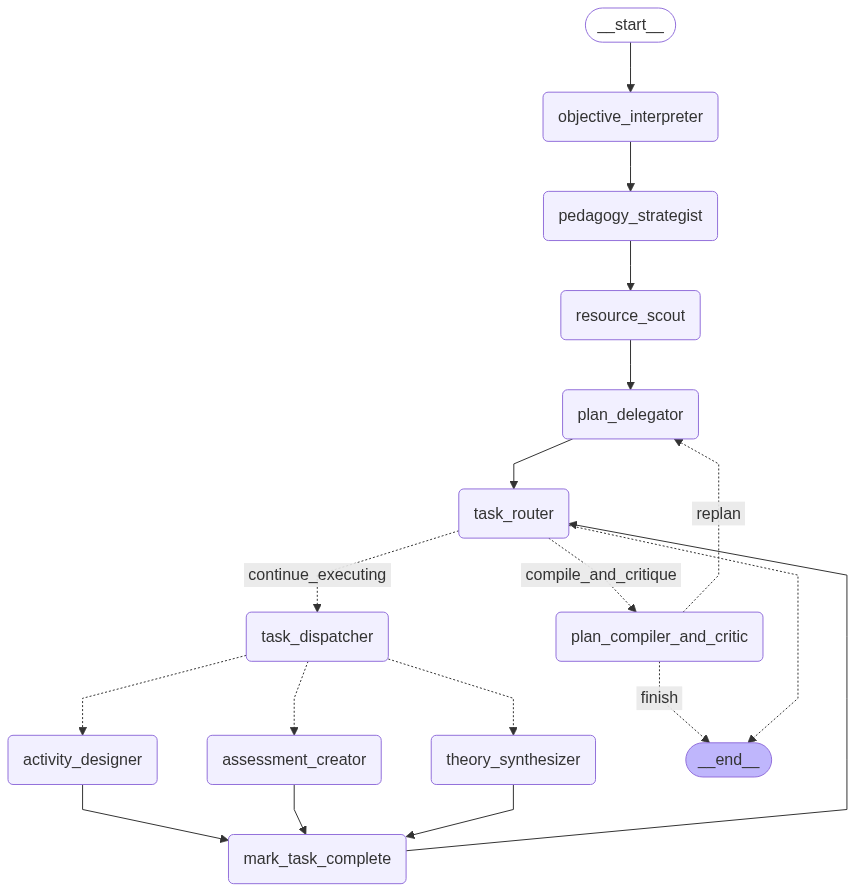

In [26]:
# ==============================================================================
# CELL 4 (Hoàn chỉnh v5.0): LẮP RÁP GRAPH (LOẠI BỎ NHÁNH UNKNOWN)
# ==============================================================================
from typing import Literal, Dict, Any

# --- Node tiện ích (Không thay đổi logic) ---
def mark_task_complete(state: "TeacherStateV3") -> Dict[str, Any]:
    """Đánh dấu nhiệm vụ hiện tại là 'completed' và xóa current_task_id."""
    task_list = state.get("task_list", [])
    current_task_id = state.get("current_task_id")
    if not task_list or current_task_id is None: return {}
    
    new_task_list = [t.copy() for t in task_list]
    for task in new_task_list:
        if task.get("task_id") == current_task_id:
            task["status"] = "completed"
            break
            
    return {"task_list": new_task_list, "current_task_id": None}
    
def task_router_node(state: "TeacherStateV3") -> Dict[str, Any]:
    """Kiểm tra xem còn nhiệm vụ nào ở trạng thái 'pending' không."""
    print_step("\n---\n### 🔄 `Router`: Đang kiểm tra nhiệm vụ...")
    task_list = state.get("task_list", [])
    next_task = next((task for task in task_list if task.get("status") == "pending"), None)
    
    if next_task:
        print_step(f"Nhiệm vụ tiếp theo: '{next_task['task_name']}' (ID: {next_task['task_id']})")
        return {"current_task_id": next_task['task_id']}
    else:
        print_step("Hết nhiệm vụ, chuyển sang node Compiler & Critic.")
        return {"current_task_id": None}

# === DISPATCHER ĐƯỢC NÂNG CẤP (Loại bỏ 'unknown' và thêm xử lý lỗi) ===
async def task_dispatcher_agent(state: "TeacherStateV3") -> Dict[str, Any]:
    """
    Phân loại nhiệm vụ hiện tại và quyết định agent nào sẽ thực hiện.
    Đã loại bỏ nhánh 'unknown' và thêm fallback an toàn.
    """
    print_step("\n---\n### 🚚 `Agent: Task Dispatcher` (v5.0) Bắt đầu...")
    task_to_run = next((t for t in state['task_list'] if t['task_id'] == state['current_task_id']), None)
    
    # Fallback an toàn nếu không tìm thấy task (trường hợp hiếm)
    if not task_to_run:
        print_warning("Dispatcher không tìm thấy task, sẽ bỏ qua bước này.")
        return {"next_agent": "mark_task_complete"}

    task_description = task_to_run['task_description']
    
    # Sử dụng lại SYSTEM_PERSONA_PROMPT để đảm bảo tính nhất quán
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **Nhiệm vụ:** Phân loại nhiệm vụ sau vào agent phù hợp nhất từ danh sách cho sẵn.
    **DANH SÁCH AGENT HỢP LỆ:** 'activity_designer', 'theory_synthesizer', 'assessment_creator'.

    **NHIỆM VỤ CẦN PHÂN LOẠI:** "{task_description}"
    
    **GỢI Ý PHÂN LOẠI:**
    - Nhiệm vụ về 'ôn tập', 'lý thuyết', 'hệ thống hóa' -> giao cho 'theory_synthesizer'.
    - Nhiệm vụ về 'vận dụng', 'thực hành', 'bài toán thực tế' -> giao cho 'activity_designer'.
    - Nhiệm vụ về 'đánh giá', 'bài tập', 'kiểm tra' -> giao cho 'assessment_creator'.

    **YÊU CẦU ĐỊNH DẠNG JSON:** Trả về JSON với key duy nhất là `agent_category`.
    """
    structured_llm = llm.with_structured_output(TaskClassification)
    
    try:
        classification_result = await structured_llm.ainvoke(prompt)
        next_agent = classification_result.agent_category
    except Exception as e:
        # Xử lý lỗi tin cậy: Nếu LLM không thể phân loại, giao cho agent mặc định là 'activity_designer'
        print_warning(f"Lỗi tại Dispatcher khi phân loại: {e}. Giao nhiệm vụ cho agent mặc định 'activity_designer'.")
        next_agent = "activity_designer"
    
    print_step(f"--- 🚚 `Dispatcher`: Giao nhiệm vụ cho `{next_agent}`.")
    return {"next_agent": next_agent}

# --- Các hàm điều hướng (Routing Functions - Không đổi) ---
def route_after_router(state: "TeacherStateV3") -> Literal["continue_executing", "compile_and_critique"]:
    """Quyết định tiếp tục vòng lặp task hay chuyển sang bước tổng hợp."""
    if state.get("current_task_id") is None:
        return "compile_and_critique"
    else:
        return "continue_executing"

def route_after_compilation(state: "TeacherStateV3") -> Literal["finish", "replan"]:
    """Quyết định kết thúc hay yêu cầu lập kế hoạch lại dựa trên phản hồi của Critic."""
    if state.get("reflection_notes"):
        print_step("ROUTER: Phát hiện phản hồi từ Critic. Yêu cầu hệ thống lập kế hoạch lại.")
        return "replan"
    else:
        print_step("ROUTER: Critic đã hài lòng. Kết thúc quy trình.")
        return "finish"

# --- XÂY DỰNG GRAPH PHIÊN BẢN 5.0 ---
workflow = StateGraph(TeacherStateV3)

# 1. Thêm tất cả các node vào graph
workflow.add_node("objective_interpreter", objective_interpreter_agent)
workflow.add_node("pedagogy_strategist", pedagogy_strategist_agent)
workflow.add_node("resource_scout", resource_scout_agent)
workflow.add_node("plan_delegator", plan_delegator_agent)
workflow.add_node("task_router", task_router_node)
workflow.add_node("task_dispatcher", task_dispatcher_agent)
workflow.add_node("theory_synthesizer", theory_synthesizer_agent)
workflow.add_node("activity_designer", activity_designer_agent)
workflow.add_node("assessment_creator", assessment_creator_agent)
workflow.add_node("mark_task_complete", mark_task_complete)
workflow.add_node("plan_compiler_and_critic", plan_compiler_and_critic_agent)

# 2. Kết nối các bước tuần tự ban đầu
workflow.set_entry_point("objective_interpreter")
workflow.add_edge("objective_interpreter", "pedagogy_strategist")
workflow.add_edge("pedagogy_strategist", "resource_scout")
workflow.add_edge("resource_scout", "plan_delegator")

# 3. Bắt đầu vòng lặp xử lý nhiệm vụ
workflow.add_edge("plan_delegator", "task_router")

# 4. Từ Router, quyết định đi đâu tiếp
workflow.add_conditional_edges(
    "task_router",
    route_after_router,
    {
        "continue_executing": "task_dispatcher", 
        "compile_and_critique": "plan_compiler_and_critic"
    }
)

# 5. Từ Dispatcher, phân nhánh đến các agent thực thi (đã loại bỏ 'unknown')
workflow.add_conditional_edges(
    "task_dispatcher",
    lambda state: state["next_agent"],
    {
        "activity_designer": "activity_designer",
        "assessment_creator": "assessment_creator",
        "theory_synthesizer": "theory_synthesizer",
    }
)

# 6. Sau khi agent thực thi xong, quay lại vòng lặp
workflow.add_edge("activity_designer", "mark_task_complete")
workflow.add_edge("assessment_creator", "mark_task_complete")
workflow.add_edge("theory_synthesizer", "mark_task_complete")
workflow.add_edge("mark_task_complete", "task_router")

# 7. Thiết lập vòng lặp tự sửa lỗi
workflow.add_conditional_edges(
    "plan_compiler_and_critic",
    route_after_compilation,
    {
        "replan": "plan_delegator",  # Nếu cần sửa, quay lại bước lập kế hoạch
        "finish": END                # Nếu ổn, kết thúc
    }
)

# 8. Biên dịch Graph
app = workflow.compile()
print("✅ Graph 5.0 (với Persona Sư phạm và Tư duy Phản biện) đã được biên dịch thành công.")

# 9. Vẽ biểu đồ để kiểm tra trực quan
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Lỗi vẽ biểu đồ: {e}")

In [27]:
# ==============================================================================
# CELL 5: CHẠY THỬ NGHIỆM VỚI GRAPH V3.0
# ==============================================================================

async def run_graph_v3(user_request: str):
    initial_state = {
        "messages": [HumanMessage(content=user_request)],
        "agent_outputs": {},
    }
    console.print(f"\n[bold magenta]🚀 BẮT ĐẦU QUY TRÌNH V3.0 VỚI YÊU CẦU:[/bold magenta]\n> {user_request}")
    config = {"recursion_limit": 100} # Tăng giới hạn đệ quy để cho phép vòng lặp
    
    final_state_result = None
    async for event in app.astream(initial_state, config=config):
        for node_name, node_output in event.items():
            console.print(f"\n[bold yellow]------- Hoàn thành bước: {node_name} -------[/bold yellow]")
            final_state_result = node_output

    console.print("\n[bold magenta]🏁 KẾT THÚC QUY TRÌNH V3.0.[/bold magenta]")
    if final_state_result and final_state_result.get("final_lesson_plan"):
        console.print("\n[bold green]📝 GIÁO ÁN HOÀN CHỈNH (SAU KHI ĐÃ TỰ SỬA LỖI)[/bold green]")
        console.print(Markdown(final_state_result["final_lesson_plan"]))
    else:
        print_warning("Không tạo được giáo án cuối cùng. Có thể quy trình đã dừng lại do lỗi không thể khắc phục.")

# Yêu cầu cũ, nhưng kỳ vọng vào kết quả mới, tốt hơn
request_v3_test = "Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9. Mục tiêu là các em có thể vận dụng được góc nội tiếp và cung bị chắn để giải các bài toán trong phần luyện tập. Buổi học sẽ diễn ra trong 2 tiết, tổng cộng 90 phút."

# Bật log chi tiết để theo dõi quá trình
VERBOSE_MODE = True 

# Chạy thử
await run_graph_v3(request_v3_test)

🚀 BẮT ĐẦU QUY TRÌNH V3.0 VỚI YÊU CẦU:
> Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9. Mục tiêu là các em 
có thể vận dụng được góc nội tiếp và cung bị chắn để giải các bài toán trong phần luyện tập. Buổi học sẽ diễn ra 
trong 2 tiết, tổng cộng 90 phút.

> `Agent: Objective Interpreter` (v5.0) đang phân tích mục tiêu...

✔️ Mục tiêu & Ràng buộc đã phân tích:

{
│   'action_verb': 'vận dụng',
│   'bloom_level': 3,
│   'topic': 'Đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'grade_level': '9',
│   'constraints': {
│   │   'duration_minutes': 90
│   }
}

------- Hoàn thành bước: objective_interpreter -------

> 
---
### 🧑‍🏫 `Agent: Pedagogy Strategist` (v5.0) Bắt đầu...

✔️ Chiến lược sư phạm đã chọn:

{
│   'chosen_pedagogy': 'Phương pháp vấn đáp và thực hành',
│   'pedagogy_rationale': 'Để vận dụng kiến thức về đường tròn ngoại tiếp và đường tròn nội tiếp, học sinh lớp 9 cần được tạo điều kiện để phát triển kỹ năng giải quyết vấn đề và tư duy logic. Phương pháp vấn đáp và thực hành sẽ giúp học sinh được tham gia tích cực vào quá trình học tập, được hướng dẫn và được thực hành các bài tập có liên quan đến đường tròn ngoại tiếp và đường tròn nội tiếp. Bằng cách này, học sinh sẽ được phát triển kỹ năng giải quyết vấn đề, kỹ năng tư duy logic và kỹ năng làm việc độc lập.'
}

------- Hoàn thành bước: pedagogy_strategist -------

> 
---
### 📚 `Agent: Resource Scout (RAG)` (v5.0) Bắt đầu...

✔️ Tài liệu RAG đã tìm thấy và tóm tắt:

{
│   'source': 'Sách giáo khoa Toán 9 (từ RAG)',
│   'summary': 'Here is a summary of the key concepts, definitions, and formulas related to "Tangent and Secant Lines" from the provided text:\n\n**Definitions:**\n\n* Two lines are said to **intersect** if they have exactly two common points.\n* Two lines are said to **touch** or **be tangent** if they have exactly one common point, called the **point of tangency**.\n* Two lines are said to **not intersect** if they have no common points.\n\n**Theorems:**\n\n* If a line intersects a circle, then the distance from the center of the circle to the line is less than the radius of the circle.\n* If a line touches a circle, then the distance from the center of the circle to the line is equal to the radius of the circle.\n* If a line does not intersect a circle, then the distance from the center of the circle to the line is greater than the radius of the circle.\n\n**Tangent Line Theorem:**\n\n* If a line passes through a point on a circle and is perpendicular to the radius passing through that point, then the line is a tangent line to the circle.\n\n**Key Concepts:**\n\n* Position of a line relative to a circle: intersecting, touching, or not intersecting.\n* Distance from the center of a circle to a line.\n* Tangent line to a circle.\n\n**Formulas:**\n\n* None mentioned in the provided text.\n\nNote that the text also mentions other topics, such as quadratic equations and linear equations, but they are not directly related to the topic of tangent and secant lines.'
}

------- Hoàn thành bước: resource_scout -------

> 
---
### 👷 `Agent: Plan Delegator` (v5.0) đang lập kế hoạch chiến lược...

✔️ Đã tạo 4 nhiệm vụ chiến lược:

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Ôn tập lý thuyết về đường tròn ngoại tiếp và đường tròn nội tiếp',
│   │   'task_description': 'Học sinh ôn tập lại các công thức và định nghĩa về đường tròn ngoại tiếp và đường tròn nội tiếp, bao gồm công thức tính bán kính, đường kính, chu vi và diện tích của đường tròn.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Tính chu vi và diện tích của đường tròn',
│   │   'task_description': 'Cho học sinh một số bài toán tính chu vi và diện tích của đường tròn, sử dụng công thức đã học. Ví dụ: Tính chu vi và diện tích của đường tròn có bán kính là 4cm.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Xác định tâm và bán kính của đường tròn ngoại tiếp',
│   │   'task_description': 'Cho học sinh một số bài toán xác định tâm và bán kính của đường tròn ngoại tiếp một tam giác, sử dụng các công thức và định lý đã học. Ví dụ: Cho tam giác ABC có các cạnh AB = 3cm, BC = 4cm, CA = 5cm. Xác định tâm và bán kính của đường tròn ngoại tiếp tam giác ABC.',
│   │   'estimated_duration': 25,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Bài đánh giá: Đường tròn ngoại tiếp và đường tròn nội tiếp',
│   │   'task_description': 'Cho học sinh một số bài toán tổng hợp về đường tròn ngoại tiếp và đường tròn nội tiếp, bao gồm tính chu vi, diện tích, xác định tâm và bán kính. Ví dụ: Cho hình tròn có chu vi là 16π cm. Xác định bán kính và diện tích của hình tròn.',
│   │   'estimated_duration': 30,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> 
---
### 🔄 `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Ôn tập lý thuyết về đường tròn ngoại tiếp và đường tròn nội tiếp' (ID: 0)

------- Hoàn thành bước: task_router -------

> 
---
### 🚚 `Agent: Task Dispatcher` (v5.0) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v5.0) đang thiết kế hoạt động lý thuyết...

✔️ Hoạt động lý thuyết đã thiết kế:

{
│   'activity_name': 'Ôn tập đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'description': 'Hoàn thành các câu hỏi trắc nghiệm nhanh để ôn tập lại các công thức và định nghĩa về đường tròn ngoại tiếp và đường tròn nội tiếp.',
│   'duration_minutes': 15,
│   'activity_type': 'Trắc nghiệm nhanh'
}

------- Hoàn thành bước: theory_synthesizer -------

------- Hoàn thành bước: mark_task_complete -------

> 
---
### 🔄 `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Tính chu vi và diện tích của đường tròn' (ID: 1)

------- Hoàn thành bước: task_router -------

> 
---
### 🚚 `Agent: Task Dispatcher` (v5.0) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v5.0) đang thiết kế hoạt động VẬN DỤNG CỤ THỂ...

✔️ Hoạt động vận dụng đã thiết kế:

{
│   'activity_name': 'Tính chu vi và diện tích của đường tròn trong thiết kế logo',
│   'description': 'Công ty thiết kế logo cần tạo một logo hình tròn cho một công ty mới. Họ muốn logo có bán kính là 4cm. Hãy tính chu vi và diện tích của logo này.',
│   'duration_minutes': 20,
│   'activity_type': 'Bài toán tính chu vi và diện tích của đường tròn'
}

------- Hoàn thành bước: activity_designer -------

------- Hoàn thành bước: mark_task_complete -------

> 
---
### 🔄 `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Xác định tâm và bán kính của đường tròn ngoại tiếp' (ID: 2)

------- Hoàn thành bước: task_router -------

> 
---
### 🚚 `Agent: Task Dispatcher` (v5.0) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v5.0) đang thiết kế hoạt động VẬN DỤNG CỤ THỂ...

✔️ Hoạt động vận dụng đã thiết kế:

{
│   'activity_name': 'Tìm tâm và bán kính của đường tròn ngoại tiếp tam giác trong thiết kế kiến trúc',
│   'description': 'Một kiến trúc sư đang thiết kế một công trình xây dựng và cần tìm tâm và bán kính của đường tròn ngoại tiếp một tam giác có các cạnh là 6m, 8m và 10m. Hãy giúp kiến trúc sư tìm tâm và bán kính của đường tròn đó.',
│   'duration_minutes': 25,
│   'activity_type': 'Bài toán thực tế'
}

------- Hoàn thành bước: activity_designer -------

------- Hoàn thành bước: mark_task_complete -------

> 
---
### 🔄 `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Bài đánh giá: Đường tròn ngoại tiếp và đường tròn nội tiếp' (ID: 3)

------- Hoàn thành bước: task_router -------

> 
---
### 🚚 `Agent: Task Dispatcher` (v5.0) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v5.0) đang thiết kế hoạt động VẬN DỤNG CỤ THỂ...

✔️ Hoạt động vận dụng đã thiết kế:

{
│   'activity_name': 'Tính toán đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'description': 'Một công ty sản xuất bánh xe đạp cần tính toán đường tròn ngoại tiếp và đường tròn nội tiếp của bánh xe để sản xuất bánh xe đạt tiêu chuẩn. Cho hình tròn có chu vi là 16π cm. Xác định bán kính và diện tích của hình tròn.',
│   'duration_minutes': 30,
│   'activity_type': 'Bài toán tổng hợp về đường tròn ngoại tiếp và đường tròn nội tiếp'
}

------- Hoàn thành bước: activity_designer -------

------- Hoàn thành bước: mark_task_complete -------

> 
---
### 🔄 `Router`: Đang kiểm tra nhiệm vụ...

> Hết nhiệm vụ, chuyển sang node Compiler & Critic.

------- Hoàn thành bước: task_router -------

> `Agent: Plan Compiler & Critic` (v5.0) đang tổng hợp và đánh giá giáo án...

> CRITIC: Kế hoạch hợp lệ! Bắt đầu tổng hợp giáo án theo mẫu chuyên nghiệp.

> ROUTER: Critic đã hài lòng. Kết thúc quy trình.

------- Hoàn thành bước: plan_compiler_and_critic -------

🏁 KẾT THÚC QUY TRÌNH V3.0.

📝 GIÁO ÁN HOÀN CHỈNH (SAU KHI ĐÃ TỰ SỬA LỖI)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                              GIÁO ÁN: Đường tròn ngoại tiếp và đường tròn nội tiếp                              ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


                                                I. THÔNG TIN CHUNG                                                 

 • Môn học: Toán                                                                                                   
 • Lớp: 9                                                                                                          
 • Thời lượng dự kiến: 90 phút                                                                                     


                                               II. MỤC TIÊU BÀI HỌC                                                

 • Học sinh có thể vận dụng được các tỉ số lượng giác để giải các bài toán thực tế.                                
 • Rèn luyện kỹ năng mô hình hóa toán học và giải quyết vấn đề.                                                    


                                              III. TIẾN TRÌNH DẠY HỌC                                              

                    Hoạt động 1: Ôn tập đường tròn ngoại tiếp và đường tròn nội tiếp (15 phút)                     

 • Loại hình tổ chức: Trắc nghiệm nhanh                                                                            
 • Mô tả chi tiết: Hoàn thành các câu hỏi trắc nghiệm nhanh để ôn tập lại các công thức và định nghĩa về đường tròn
   ngoại tiếp và đường tròn nội tiếp.                                                                              

                Hoạt động 2: Tính chu vi và diện tích của đường tròn trong thiết kế logo (20 phút)                 

 • Loại hình tổ chức: Bài toán tính chu vi và diện tích của đường tròn                                             
 • Mô tả chi tiết: Công ty thiết kế logo cần tạo một logo hình tròn cho một công ty mới. Họ muốn logo có bán kính  
   là 4cm. Hãy tính chu vi và diện tích của logo này.                                                              

      Hoạt động 3: Tìm tâm và bán kính của đường tròn ngoại tiếp tam giác trong thiết kế kiến trúc (25 phút)       

 • Loại hình tổ chức: Bài toán thực tế                                                                             
 • Mô tả chi tiết: Một kiến trúc sư đang thiết kế một công trình xây dựng và cần tìm tâm và bán kính của đường tròn
   ngoại tiếp một tam giác có các cạnh là 6m, 8m và 10m. Hãy giúp kiến trúc sư tìm tâm và bán kính của đường tròn  
   đó.                                                                                                             

                   Hoạt động 4: Tính toán đường tròn ngoại tiếp và đường tròn nội tiếp (30 phút)                   

 • Loại hình tổ chức: Bài toán tổng hợp về đường tròn ngoại tiếp và đường tròn nội tiếp                            
 • Mô tả chi tiết: Một công ty sản xuất bánh xe đạp cần tính toán đường tròn ngoại tiếp và đường tròn nội tiếp của 
   bánh xe để sản xuất bánh xe đạt tiêu chuẩn. Cho hình tròn có chu vi là 16π cm. Xác định bán kính và diện tích   
   của hình tròn.                                                                                                  


                                              IV. ĐÁNH GIÁ VÀ CỦNG CỐ                                              


                                            V. TÀI NGUYÊN & PHƯƠNG TIỆN                                            

 • Nguồn: Sách giáo khoa Toán 9 (từ RAG)                                                                           
 • Tóm tắt kiến thức cốt lõi: Here is a summary of the key concepts, definitions, and formulas related to "Tangent 
   and Secant Lines" from the provided text:                                                                       

Definitions:                      